# Step 1: Load and Combine Data

In [1]:
import pandas as pd

# Load datasets
X_train = pd.read_csv("X_train.csv")  # Peptide sequences
train_labels = pd.read_csv("label_train.csv")  # Corresponding labels

# Combine features and labels
train_data = pd.concat([X_train, train_labels], axis=1)
train_data.columns = ['peptide_sequence', 'label']

# Load test data
X_test = pd.read_csv("X_test.csv")
test_labels = pd.read_csv("label_test.csv")
test_data = pd.concat([X_test, test_labels], axis=1)
test_data.columns = ['peptide_sequence', 'label']

In [2]:
train_data.head()

,peptide_sequence,label
0,DDRHKIVNVDQRQYG,1
1,EGNRPTNSIVFTKLT,1
2,TRQGGYSNDNTVIFR,1
3,LHGETFPYTAFDNNC,1
4,VMALEPVVGAAIAAP,1


In [3]:
len(train_data)

2872

In [4]:
test_data.head()

,peptide_sequence,label
0,TPETLFEIGSVSKTFTAT,1.0
1,HPGNTILHVDTIYNRPSNTT,1.0
2,YWAGIEFDVTHKGMALLHRL,1.0
3,EQGLLYMPQELAVSD,1.0
4,GARGFFQARHLEMDA,1.0


In [5]:
len(test_data)

342

# Step 2: TF-IDF Vectorization

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer for unigrams and bigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Monogram and bigram

# Transform training and test data
X_train_tfidf = vectorizer.fit_transform(train_data['peptide_sequence'])
X_test_tfidf = vectorizer.transform(test_data['peptide_sequence'])

print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

TF-IDF feature matrix shape: (2872, 2872)


# Step 3: Graph Neural Network (GNN)
**To use a GNN, we need to construct a graph representation from the TF-IDF vectors. This includes:**

1. Building a similarity graph between samples (e.g., k-nearest neighbors).
2. Training a GNN on this graph.
3. Build a Graph Representation

cosine similarity is used to create edges between samples based on TF-IDF features. 

In [7]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Create a cosine similarity matrix for the training data
similarity_matrix = cosine_similarity(X_train_tfidf)

# Threshold to create edges (e.g., top-k or similarity > 0.5)
threshold = 0.5
edges = np.argwhere(similarity_matrix > threshold)
edges = edges[edges[:, 0] != edges[:, 1]]  # Remove self-loops


In [8]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder

# Convert data to PyTorch tensors
edge_index = torch.tensor(edges.T, dtype=torch.long)  # Edge list
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float)
y_train_tensor = torch.tensor(LabelEncoder().fit_transform(train_data['label']), dtype=torch.long)

# Create a PyTorch Geometric Data object
data = Data(x=X_train_tensor, edge_index=edge_index, y=y_train_tensor)

# Define a simple GNN model
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Instantiate the model
input_dim = X_train_tensor.shape[1]
hidden_dim = 64
output_dim = len(train_data['label'].unique())
model = GNN(input_dim, hidden_dim, output_dim)

# Step 4: Train the GNN

In [9]:
import torch.optim as optim
from torch_geometric.loader import DataLoader

# DataLoader for batching (optional, depending on dataset size)
loader = DataLoader([data], batch_size=32, shuffle=True)

# Define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(20):
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.6933659911155701
Epoch 2, Loss: 0.6600182056427002
Epoch 3, Loss: 0.6246525049209595
Epoch 4, Loss: 0.5829913020133972
Epoch 5, Loss: 0.5357642769813538
Epoch 6, Loss: 0.48325589299201965
Epoch 7, Loss: 0.42768189311027527
Epoch 8, Loss: 0.37066134810447693
Epoch 9, Loss: 0.3130836486816406
Epoch 10, Loss: 0.25654491782188416
Epoch 11, Loss: 0.2038552165031433
Epoch 12, Loss: 0.15764416754245758
Epoch 13, Loss: 0.11878563463687897
Epoch 14, Loss: 0.08758443593978882
Epoch 15, Loss: 0.06355208903551102
Epoch 16, Loss: 0.045610152184963226
Epoch 17, Loss: 0.03252970427274704
Epoch 18, Loss: 0.023171400651335716
Epoch 19, Loss: 0.016561947762966156
Epoch 20, Loss: 0.011925702914595604


# Step 5: Evaluate the GNN

In [10]:
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Create a cosine similarity graph for the test data
test_similarity_matrix = cosine_similarity(X_test_tfidf)

# Threshold to create edges (e.g., similarity > 0.5)
test_edges = np.argwhere(test_similarity_matrix > 0.5)
test_edges = test_edges[test_edges[:, 0] != test_edges[:, 1]]  # Remove self-loops

# Convert to PyTorch tensor
test_edge_index = torch.tensor(test_edges.T, dtype=torch.long)

# Create test Data object for PyTorch Geometric
test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float)
test_y_tensor = torch.tensor(test_data['label'].values, dtype=torch.long)
test_graph = Data(x=test_tensor, edge_index=test_edge_index, y=test_y_tensor)


In [11]:
# Evaluate model on test data
model.eval()
with torch.no_grad():
    test_output = model(test_graph)
    test_predictions = test_output.argmax(dim=1).cpu().numpy()

In [12]:
test_data

,peptide_sequence,label
0,TPETLFEIGSVSKTFTAT,1.0
1,HPGNTILHVDTIYNRPSNTT,1.0
2,YWAGIEFDVTHKGMALLHRL,1.0
3,EQGLLYMPQELAVSD,1.0
4,GARGFFQARHLEMDA,1.0
...,...,...
337,FKRALGARSKQPPPR,0.0
338,ESDCDWLVNASNPGH,0.0
339,QWFYDGYPTFGQHPETS,0.0
340,QLKLQTRVYMKLKHVRAW,0.0


In [13]:
test_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [14]:
print(len(test_data['label']))  # Should print 342
print(len(test_predictions))    # Should print 342

342
342


In [15]:
print(len(test_data['label']), len(test_predictions))

342 342


In [16]:
test_data['label'] = test_data['label'].fillna(0.0)

In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report

# Calculate metrics
cm = confusion_matrix(test_data['label'], test_predictions)
precision = precision_score(test_data['label'], test_predictions, average='weighted')
recall = recall_score(test_data['label'], test_predictions, average='weighted')

# Print metrics
print("Confusion Matrix:")
print(cm)
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(test_data['label'], test_predictions))

Confusion Matrix:
[[172   0]
 [170   0]]
Precision (weighted): 0.2529
Recall (weighted): 0.5029

Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       172
         1.0       0.00      0.00      0.00       170

    accuracy                           0.50       342
   macro avg       0.25      0.50      0.33       342
weighted avg       0.25      0.50      0.34       342



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classifi

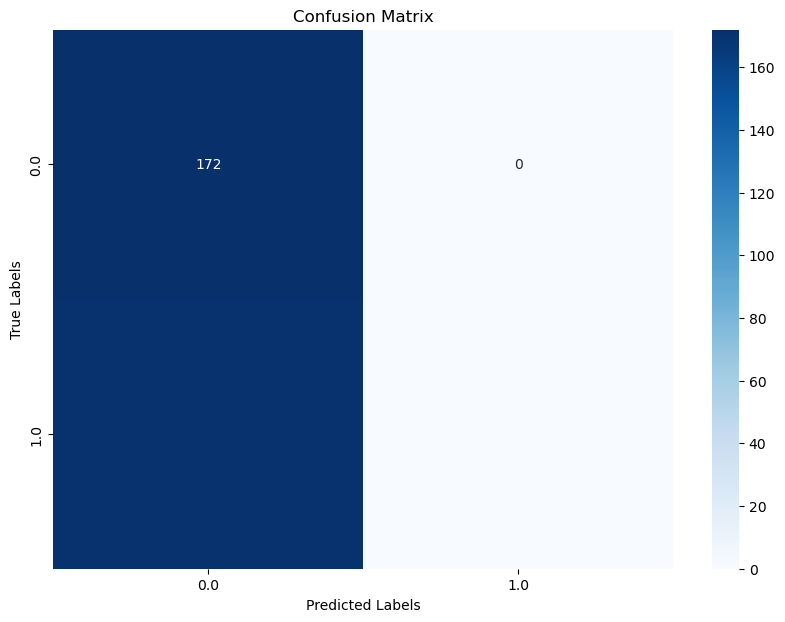

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(test_data['label'], test_predictions)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_data['label']),
            yticklabels=np.unique(test_data['label']))

# Add labels and title
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Display the plot
plt.show()

In [19]:
from sklearn.metrics import matthews_corrcoef

# Calculate the Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(test_data['label'], test_predictions)

# Print the MCC score
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

Matthews Correlation Coefficient (MCC): 0.0000


In [20]:
sample_index = 0  # Example: picking the first sample from the test set
sample_text = test_data.iloc[sample_index]['peptide_sequence']  # Access the sample's text

# Display the sample text (optional)
print(f"Sample Text: {sample_text}")

Sample Text: TPETLFEIGSVSKTFTAT


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Monogram + Bigram

# Fit the vectorizer on your training data text
tfidf_vectorizer.fit(train_data['peptide_sequence'])  # Assuming 'text' column in the training data

TfidfVectorizer(ngram_range=(1, 2))

In [25]:
# Now, transform the sample text into TF-IDF features
sample_tfidf = tfidf_vectorizer.transform([sample_text])  # Transform the sample text

# Predict the class for the sample using your trained model
sample_prediction = model.predict(sample_tfidf)
print(f"Predicted label for the sample: {sample_prediction[0]}")

AttributeError: 'GNN' object has no attribute 'predict'